<a href="https://colab.research.google.com/github/ICMAG/Fuzzy/blob/main/KerasLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A temperature-forecasting example
Throughout this chapter, all of our code examples will target a single problem: predicting the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, recorded over the
recent past by a set of sensors on the roof of a building. As you will see, it’s a fairly challenging problem!
 We’ll use this temperature-forecasting task to highlight what makes timeseries data
fundamentally different from the kinds of datasets you’ve encountered so far. You’ll
282 CHAPTER 10 Deep learning for timeseries
see that densely connected networks and convolutional networks aren’t well-equipped
to deal with this kind of dataset, while a different kind of machine learning technique—recurrent neural networks (RNNs)—really shines on this type of problem.
 We’ll work with a weather timeseries dataset recorded at the weather station at the
Max Planck Institute for Biogeochemistry in Jena, Germany.1
 In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on)
were recorded every 10 minutes over several years. The original data goes back to
2003, but the subset of the data we’ll download is limited to 2009–2016.

In [3]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-12-01 16:35:25--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.234.56, 52.217.129.200, 52.216.58.248, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.234.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  13.9MB/s    in 0.9s    

2022-12-01 16:35:27 (13.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Cargar y analizar el Data SET

In [4]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
 data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Now, convert all 420,551 lines of data into NumPy arrays: one array for the temperature (in degrees Celsius), and another one for the rest of the data—the features we
will use to predict future temperatures. Note that we discard the “Date Time” column.



(420451,)
(420451, 14)


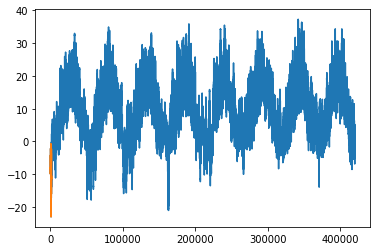

In [5]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.plot(range(1440), temperature[:1440])
print(temperature.shape)
print(temperature.data)
print(raw_data.shape)


On this plot, you can see daily periodicity, especially for the last 4 days. Also note that
this 10-day period must be coming from a fairly cold winter month.
With our dataset, if you were trying to predict average temperature for the next month
given a few months of past data, the problem would be easy, due to the reliable yearscale periodicity of the data. But looking at the data over a scale of days, the temperature
looks a lot more chaotic. Is this timeseries predictable at a daily scale? Let’s find out.
In all our experiments, we’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing. When working with timeseries
data, it’s important to use validation and test data that is more recent than the training data, because you’re trying to predict the future given the past, not the reverse,
and your validation/test splits should reflect that. Some problems happen to be considerably simpler if you reverse the time axis!
>>> num_train_samples = int(0.5 * len(raw_data))
>>> num_val_samples = int(0.25 * len(raw_data))
>>> num_test_samples = len(raw_data) - num_train_samples - num_val_samples
Always look for periodicity in your data
Periodicity over multiple timescales is an important and very common property of
timeseries data. Whether you’re looking at the weather, mall parking occupancy, traffic to a website, sales of a grocery store, or steps logged in a fitness tracker, you’ll
see daily cycles and yearly cycles (human-generated data also tends to feature
weekly cycles). When exploring your data, make sure to look for these patterns.

Listing 10.5 Computing the number of samples we’ll use for each data split


In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Preparing the data
The exact formulation of the problem will be as follows: given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?
First, let’s preprocess the data to a format a neural network can ingest. This is
easy: the data is already numerical, so you don’t need to do any vectorization. But each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per mole, is around 3). We’ll normalize each timeseries independently so that they all take small values on a similar scale. We’re going to use the first 210,225 timesteps as training data, so we’ll compute the mean and standard deviation only on this fraction of the data.
Next, let’s create a Dataset object that yields batches of data from the past five days along with a target temperature 24 hours in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate memory for every sample. Instead, we’ll generate the samples on the fly while only keeping in memory the original raw_data and temperature arrays, and nothing more. We could easily write a Python generator to do this, but there’s a built-in dataset utility in Keras that does just that (timeseries_dataset_from_array()), so we can save ourselves some work by using it. You can generally use it for any kind of timeseries forecasting task. Understanding timeseries_dataset_from_array() To understand what timeseries_dataset_from_array() does, let’s look at a simple example. The general idea is that you provide an array of timeseries data (the data argument , and timeseries_dataset_from_array() gives you windows extracted from the original timeseries (we’ll call them “sequences”). For example, if you use data = [0 1 2 3 4 5 6] and sequence_length=3, then timeseries_dataset_from_array() will generate the following samples: [0 1 2], [1 2 3], [2 3 4], [3 4 5], [4 5 6]. (continued) You can also pass a targets argument (an array) to timeseries_dataset_ from_array(). The first entry of the targets array should match the desired target for the first sequence that will be generated from the data array. So if you’re doing timeseries forecasting, targets should be the same array as data, offset by some amount. For instance, with data = [0 1 2 3 4 5 6 …] and sequence_length=3, you could create a dataset to predict the next step in the series by passing targets = [3 4 5 6 …]. Let’s try it:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
data=int_sequence[:-3],
targets=int_sequence[3:],
sequence_length=3,
batch_size=2, )
for inputs, targets in dummy_dataset:
for i in range(inputs.shape[0]):
print([int(x) for x in inputs[i]], int(targets[i]))
This bit of code prints the following results:
[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7
Generate an array
of sorted integers
from 0 to 9.
The sequences
we generate will
be sampled from
[0 1 2 3 4 5 6].
The target for the sequence that
starts at data[N] will be data[N + 3].
The sequences wil

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Listing 10.7 Instantiating datasets for training, validation, and testing


In [8]:
import tensorflow as tf
from tensorflow import keras
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(raw_data[:-delay], targets = temperature[delay:], sampling_rate=sampling_rate, sequence_length=sequence_length, shuffle=True, batch_size=batch_size, start_index=0, end_index=num_train_samples)
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures. Note that the samples are randomly
shuffled, so two consecutive sequences in a batch (like samples[0] and samples[1])
aren’t necessarily temporally close.
Listing 10.8 Inspecting the output of one of our datasets


In [9]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break
  np.mean(np.abs(preds - targets))
# def evaluate_naive_method(dataset)
#   total_abs_err = 0
#   samples_seen = 0
# for samples, targets in dataset:
# preds = samples[:, -1, 1] * std[1] + mean[1]
# total_abs_err += np.sum(np.abs(preds - targets))
# samples_seen += samples.shape[0]
# return total_abs_err / samples_seen
# print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
# print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

samples shape: (256, 120, 14)
targets shape: (256,)


This common-sense baseline achieves a validation MAE of 2.44 degrees Celsius and a test MAE of 2.62 degrees Celsius. So if you always assume that the temperature 24 hours in the future will be the same as it is now, you will be off by two and a half degrees on average. It’s not too bad, but you probably won’t launch a weather forecasting service based on this heuristic. Now the game is to use your knowledge of deep learning to do better. Listing 10.9 Computing the common-sense baseline MAE



Epoch 1/10
819/819 [==============================] - 45s 51ms/step - loss: 13.2111 - mae: 2.8136 - val_loss: 10.3561 - val_mae: 2.5329
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 9.2283 - mae: 2.3962 - val_loss: 10.1643 - val_mae: 2.5094
Epoch 3/10
819/819 [==============================] - 44s 53ms/step - loss: 8.3878 - mae: 2.2832 - val_loss: 11.5998 - val_mae: 2.6867
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 7.9110 - mae: 2.2181 - val_loss: 11.1901 - val_mae: 2.6515
Epoch 5/10
819/819 [==============================] - 40s 49ms/step - loss: 7.5702 - mae: 2.1702 - val_loss: 10.4958 - val_mae: 2.5586
Epoch 6/10
819/819 [==============================] - 41s 50ms/step - loss: 7.2988 - mae: 2.1341 - val_loss: 10.5330 - val_mae: 2.5639
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 7.0882 - mae: 2.1036 - val_loss: 10.6764 - val_mae: 2.5866
Epoch 8/10
819/819 [==============================] - 

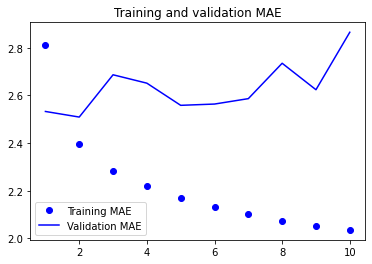

(None, 120, 14)
(None, 1)


In [10]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_dense.keras",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=10,
validation_data=val_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
print(inputs.shape)
print(outputs.shape)

10.2.4 Let’s try a 1D convolutional model
Speaking of leveraging the right architecture priors, since our input sequences feature daily cycles, perhaps a convolutional model could work. A temporal convnet could reuse the same representations across different days, much like a spatial convnet can reuse the same representations across different locations in an image.
You already know about the Conv2D and SeparableConv2D layers, which see their
inputs through small windows that swipe across 2D grids. There are also 1D and even Figure 10.3 Training and validation MAE on the Jena temperatureforecasting task with a simple, densely connected networkA temperature-forecasting example 291 3D versions of these layers: Conv1D, SeparableConv1D, and Conv3D.2 The Conv1D layer relies on 1D windows that slide across input sequences, and the Conv3D layer relies on cubic windows that slide across input volumes.
You can thus build 1D convnets, strictly analogous to 2D convnets. They’re a great fit for any sequence data that follows the translation invariance assumption (meaning that if you slide a window over the sequence, the content of the window should follow the same properties independently of the location of the window).
Let’s try one on our temperature-forecasting problem. We’ll pick an initial window length of 24, so that we look at 24 hours of data at a time (one cycle). As we downsample the sequences (via MaxPooling1D layers), we’ll reduce the  window size accordingly:

In [11]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_conv.keras",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=10,
validation_data=val_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 49s 51ms/step - loss: 22.4980 - mae: 3.7132 - val_loss: 15.5574 - val_mae: 3.1001
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 15.8935 - mae: 3.1668 - val_loss: 15.0588 - val_mae: 3.0698
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 14.4693 - mae: 3.0183 - val_loss: 14.0968 - val_mae: 2.9509
Epoch 4/10
819/819 [==============================] - 40s 49ms/step - loss: 13.5064 - mae: 2.9148 - val_loss: 14.2899 - val_mae: 2.9706
Epoch 5/10
819/819 [==============================] - 42s 50ms/step - loss: 12.8250 - mae: 2.8381 - val_loss: 14.2287 - val_mae: 2.9461
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 12.2370 - mae: 2.7710 - val_loss: 14.2089 - val_mae: 2.9673
Epoch 7/10
819/819 [==============================] - 41s 49ms/step - loss: 11.7557 - mae: 2.7140 - val_loss: 13.9442 - val_mae: 2.9368
Epoch 8/10
819/819 [============================

Neither the fully connected approach nor the convolutional approach did well, but that doesn’t mean machine learning isn’t applicable to this problem. The densely connected approach first flattened the timeseries, which removed the notion of time from the input data. The convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed order information. Let’s instead look at the data as what it is: a sequence, where causality and order matter. There’s a family of neural network architectures designed specifically for this use case: recurrent neural networks. Among them, the Long Short Term Memory (LSTM) layer has long been very popular. We’ll see in a minute how these models work, but let’s start by giving the LSTM layer a try

In [12]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_lstm.keras",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=10,
validation_data=val_dataset,
callbacks=callbacks)
# Listing 10.12 A simple LSTM-based model
# Figure 10.4 Training and validation MAE on the Jena temperatureforecasting task with a 1D convnetUnderstanding recurrent neural networks 293
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 48s 56ms/step - loss: 38.2840 - mae: 4.4748 - val_loss: 12.2013 - val_mae: 2.6763
Epoch 2/10
819/819 [==============================] - 44s 53ms/step - loss: 10.7115 - mae: 2.5439 - val_loss: 9.7887 - val_mae: 2.4392
Epoch 3/10
819/819 [==============================] - 44s 53ms/step - loss: 9.5855 - mae: 2.4120 - val_loss: 9.8008 - val_mae: 2.4363
Epoch 4/10
819/819 [==============================] - 45s 54ms/step - loss: 8.9409 - mae: 2.3305 - val_loss: 9.7080 - val_mae: 2.4270
Epoch 5/10
819/819 [==============================] - 45s 54ms/step - loss: 8.6030 - mae: 2.2831 - val_loss: 9.9191 - val_mae: 2.4528
Epoch 6/10
819/819 [==============================] - 44s 54ms/step - loss: 8.3438 - mae: 2.2494 - val_loss: 9.8104 - val_mae: 2.4342
Epoch 7/10
819/819 [==============================] - 44s 53ms/step - loss: 8.1361 - mae: 2.2213 - val_loss: 9.9506 - val_mae: 2.4545
Epoch 8/10
819/819 [==============================] - 44s 5

Listing 10.13 Pseudocode RNN
You can even flesh out the function f: the transformation of the input and state into an output will be parameterized by two matrices, W and U, and a bias vector. It’s similar to the transformation operated by a densely connected layer in a feedforward network.

That’s easy enough. In summary, an RNN is a for loop that reuses quantities computed during the previous iteration of the loop, nothing more. Of course, there are many different RNNs fitting this definition that you could build—this example is one of the simplest RNN formulations. RNNs are characterized by their step function, such as the following function in this case (see figure 10.7).
NOTE In this example, the final output is a rank-2 tensor of shape (timesteps, output_features), where each timestep is the output of the loop at
time t. Each timestep t in the output tensor contains information about timesteps 0 to t in the input sequence—about the entire past. For this reason, in many cases, you don’t need this full sequence of outputs; you just need the
last output (output_t at the end of the loop), because it already contains information about the entire sequence.
10.3.1 A recurrent layer in Keras
The process we just naively implemented in NumPy corresponds to an actual Keras
layer—the SimpleRNN layer.
There is one minor difference: SimpleRNN processes batches of sequences, like all other Keras layers, not a single sequence as in the NumPy example. This means it takes inputs of shape (batch_size, timesteps, input_features), rather than (timesteps, input_features). When specifying the shape argument of the initial Input(), note that you can set the timesteps entry to None, which enables your network to process sequences of arbitrary length.
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)
This is especially useful if your model is meant to process sequences of variable length.
However, if all of your sequences have the same length, I recommend specifying a
complete input shape, since it enables model.summary() to display output length information, which is always nice, and it can unlock some performance optimizations (see the “Note on RNN runtime performance” sidebar a little later in this chapter).
All recurrent layers in Keras (SimpleRNN, LSTM, and GRU) can be run in two different modes: they can return either full sequences of successive outputs for each timestep (a rank-3 tensor of shape (batch_size, timesteps, output_features)) or return only the last output for each input sequence (a rank-2 tensor of shape (batch_ size, output_features)). These two modes are controlled by the return_sequences constructor argument. Let’s look at an example that uses SimpleRNN and returns only the output at the last timestep.

In [13]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

# Listing 10.16 An RNN layer that can process sequences of any length
# Listing 10.17 An RNN layer that returns only its last output step
# Note that
return_sequences=False
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

(None, 16)


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=50,
validation_data=val_dataset,
callbacks=callbacks)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=50,
validation_data=val_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 340s 412ms/step - loss: 27.4473 - mae: 3.8774 - val_loss: 9.6915 - val_mae: 2.4234
Epoch 2/50
819/819 [==============================] - 337s 411ms/step - loss: 14.7469 - mae: 2.9850 - val_loss: 9.6419 - val_mae: 2.4063
Epoch 3/50
819/819 [==============================] - 356s 434ms/step - loss: 13.9641 - mae: 2.8958 - val_loss: 9.3747 - val_mae: 2.3770
Epoch 4/50
819/819 [==============================] - 334s 407ms/step - loss: 13.4187 - mae: 2.8389 - val_loss: 10.1734 - val_mae: 2.4630
Epoch 5/50
819/819 [==============================] - 339s 414ms/step - loss: 12.9360 - mae: 2.7868 - val_loss: 9.4122 - val_mae: 2.3949
Epoch 6/50
819/819 [==============================] - 339s 414ms/step - loss: 12.4362 - mae: 2.7352 - val_loss: 9.2839 - val_mae: 2.3851
Epoch 7/50
819/819 [==============================] - 343s 419ms/step - loss: 12.0525 - mae: 2.6981 - val_loss: 9.3715 - val_mae: 2.3848
Epoch 8/50
819/819 [====================

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
save_best_only=True)

In practice, you’ll rarely work with the SimpleRNN layer. It’s generally too simplistic to be of real use. In particular, SimpleRNN has a major issue: although it should theoretically be able to retain at time t information about inputs seen many timesteps before, such long-term dependencies prove impossible to learn in practice. This is due to the vanishing gradient problem, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: as you keep adding layers to a network, the network eventually becomes untrainable. The theoretical reasons for this effect were studied by Hochreiter, Schmidhuber, and Bengio in the early 1990s.3
Thankfully, SimpleRNN isn’t the only recurrent layer available in Keras. There are two others, LSTM and GRU, which were designed to address these issues.
Let’s consider the LSTM layer. The underlying Long Short-Term Memory (LSTM)
algorithm was developed by Hochreiter and Schmidhuber in 1997;4 it was the culmination of their research on the vanishing gradient problem.
This layer is a variant of the SimpleRNN layer you already know about; it adds a way to carry information across many timesteps. Imagine a conveyor belt running parallel to the sequence you’re processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when you need it. This is essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing. This should
Listing 10.18 An RNN layer that returns its full output sequence
Listing 10.19 Stacking RNN layers
3 See, for example, Yoshua Bengio, Patrice Simard, and Paolo Frasconi, “Learning Long-Term Dependencies
with Gradient Descent Is Difficult,” IEEE Transactions on Neural Networks 5, no. 2 (1994).
4 Sepp Hochreiter and Jürgen Schmidhuber, “Long Short-Term Memory,” Neural Computation 9, no. 8 (1997).298 CHAPTER 10 Deep learning for timeseries
remind you of residual connections, which you learned about in chapter 9: it’s pretty much the same idea.
To understand this process in detail, let’s start from the SimpleRNN cell (see figure 10.8). Because you’ll have a lot of weight matrices, index the W and U matrices in the cell, with the letter o (Wo and Uo) for output.